# Comrpesión de imágen con SVD

## Carga de imágen

In [1]:
from matplotlib.image import imread
from matplotlib.image import imsave
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import time

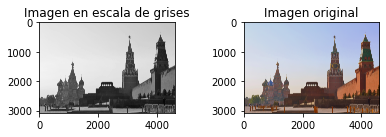

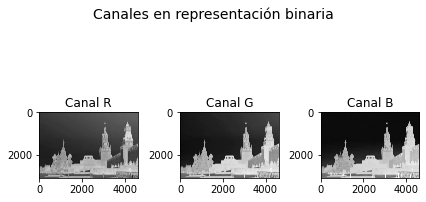

In [2]:
file = '/content/drive/MyDrive/Colab Notebooks/Análisis Matemático para IA/Moscu.jpg'
img_orig = imread(file) 
A_r = img_orig[:, :, 0] # Canal R de la imagen
A_g = img_orig[:, :, 1] # Canal G de la imagen
A_b = img_orig[:, :, 2] # Canal B de la imagen
A=np.mean(img_orig,-1); 

fig, ax = plt.subplots(1, 2)
axis = ax.flat
axis[0].imshow(A, cmap='gray')
axis[1].imshow(img_orig)
axis[0].set_title('Imagen en escala de grises')
axis[1].set_title('Imagen original')
plt.tight_layout(pad=3.0)
plt.show()

fig_1, ax_1 = plt.subplots(1, 3)
plt.suptitle("Canales en representación binaria", fontsize=14)
axis_1 = ax_1.flat
axis_1[0].imshow(A_r, cmap='binary')
axis_1[1].imshow(A_g, cmap='binary')
axis_1[2].imshow(A_b, cmap='binary')
axis_1[0].set_title('Canal R')
axis_1[1].set_title('Canal G')
axis_1[2].set_title('Canal B')
plt.tight_layout(True)
plt.show()

# Guardar la imagen original en escala de grises 
file_gray=os.path.splitext(file)[0]+'_grey'+os.path.splitext(file)[1]
imsave(file_gray,A,cmap="gray")

file_red=os.path.splitext(file)[0]+'_red'+os.path.splitext(file)[1]
imsave(file_red,A_r,cmap="gray")

file_green=os.path.splitext(file)[0]+'_green'+os.path.splitext(file)[1] 
imsave(file_green,A_g,cmap="gray")

file_blue=os.path.splitext(file)[0]+'_blue'+os.path.splitext(file)[1]
imsave(file_blue,A_b,cmap="gray")

## Implementacion de SVD en CPU

In [4]:
cpu_start = time.time()
U, S, VT=np.linalg.svd(A)
cpu_end = time.time()
print("Tiempo de ejecución cpu: {} sec".format(np.round(cpu_end-cpu_start,2)))
S=np.diag(S)

Tiempo de ejecución cpu: 40.87 sec


## Implementación de SVD en GPU con PyTorch

In [5]:
device = torch.device("cuda") 
A_tensor = torch.from_numpy(A)
A_cuda = A_tensor.to(device)
cuda_start = time.time()
U_cuda, S_cuda, V_cuda = torch.svd(A_cuda)
cuda_end = time.time()
print("Tiempo de ejecución gpu: {} sec".format(np.round(cuda_end - cuda_start,2)))
U_cuda = U_cuda.cpu().numpy()
S_cuda = S_cuda.cpu().numpy()
V_cuda = V_cuda.cpu().numpy()
S_cuda=np.diag(S_cuda)
time_red = (1-(cuda_end-cuda_start)/(cpu_end-cpu_start))*100 
print("Reducción de tiempo de ejecución: {}%".format(np.round(time_red,2)))

Tiempo de ejecución gpu: 15.89 sec
Reducción de tiempo de ejecución: 61.11%


In [6]:
def gpu_svd(A):
    A_aux = A
    A_tensor = torch.from_numpy(A_aux)
    A_cuda = A_tensor.to(device)
    U_cuda, S_cuda, V_cuda = torch.svd(A_cuda)
    U_cuda = U_cuda.cpu().numpy()
    S_cuda = S_cuda.cpu().numpy()
    V_cuda = V_cuda.cpu().numpy()
    S_cuda=np.diag(S_cuda)
    return U_cuda, S_cuda, V_cuda

## Compresión

In [7]:
def compresion(k, U, S, VT):
    return U[:,:k] @ S[0:k,:k] @ VT[:k,:]

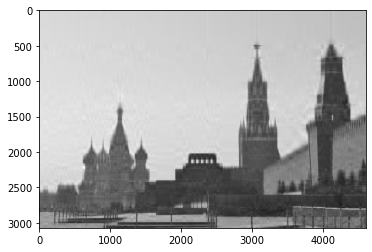

In [8]:
# Ejemplo para un número k de valores singulares determinado
k=30;
A_k = compresion(k, U, S, VT)
img=plt.imshow(A_k)
img.set_cmap('gray')
plt.show()

## Matricas

In [9]:
# Espacio reducido de archivo ss (saved space)
def saved_space(orig_path, A_k):
    file_k = os.path.splitext(orig_path)[0]+'_k'+os.path.splitext(orig_path)[1] 
    imsave(file_k,A_k,cmap="gray")
    sizeOrig=os.stat(orig_path).st_size;
    sizeRed=os.stat(file_k).st_size;
    return (sizeOrig-sizeRed)/sizeOrig; # Porcentaje de reducción.

In [10]:
print("Porcentaje de reducción: {0:.2f}%".format(saved_space(file_gray, A_k)*100))

Porcentaje de reducción: 23.20%


In [11]:
# Compression Rate (CR)
def compression_rate(A_orig, k):
    n = A_orig.shape[0]
    m = A_orig.shape[1]
    return (n*m)/(k*(n+m+1))

In [12]:
print("Compression Rate (CR): {0:.2f}".format(compression_rate(A, k)))

Compression Rate (CR): 61.43


In [13]:
# Energy Truncation
def energy_truncation(A, A_k):
    return np.linalg.norm(A_k)/np.linalg.norm(A)

In [14]:
# Error truncation (Frobenius)
def error_truncation(A, A_k):
    return np.linalg.norm(A-A_k)/np.linalg.norm(A)

In [15]:
print("Error de truncado basado en Frobenius: {0:.2f}%".format(error_truncation(A, A_k)*100))

Error de truncado basado en Frobenius: 5.61%
